In [ ]:
#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
# Load the Data

# Set train and valid directory paths

dataset = '/content/drive/MyDrive/Machinelearning&image/hymenoptera_data'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
test_directory = os.path.join(dataset, 'test')



# Batch size
bs = 32

# Number of classes
num_classes = 3
#len(os.listdir(valid_directory))  #10#2#257
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs,shuffle=False)
test_data_loader = DataLoader(data['test'], batch_size=bs,shuffle=False)

3
{0: 'benign', 1: 'keratosis', 2: 'melanoma'}


In [ ]:
from posix import X_OK
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(train_data_size, valid_data_size, test_data_size)

from os import listdir
from os.path import isfile, join
import pandas as pd
onlyfiles = [f for f in listdir(dataset+'/train'+'/benign') if isfile(join(dataset+'/train'+'/benign', f))]
print(type(onlyfiles))
H=set(onlyfiles)
print(len(H))
b=np.asarray(onlyfiles)
#X=onlyfiles.to_numpy()
# y=labels_csv[['final_labels']].to_numpy()
pd.DataFrame(b).to_csv('/content/drive/MyDrive/Machinelearning&image/files_ben.csv',index=False)
#b.to_csv('/content/drive/MyDrive/Machinelearning&image/files_ben.csv',index=False)



2002 150 600
<class 'list'>
1374


In [ ]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.to(device)

In [ ]:
# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

In [ ]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),##
    nn.Linear(256, num_classes), # Since 10 possible outputs
    #nn.LogSoftmax(dim=1) # For using NLLLoss()
)



# Convert model to be used on GPU
resnet50 = resnet50.to(device)


In [ ]:
# Define Optimizer and Loss Function
#loss_func = nn.NLLLoss()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr =0.0001)

In [ ]:
def train_and_validate(model, loss_criterion, optimizer, epochs=50):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')

        #from sklearn.metrics import balanced_accuracy_score
        #balacc=balanced_accuracy_score(labels,predictions)
            
    return model, history, best_epoch
    

In [ ]:
# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 25 epochs
num_epochs = 60
trained_model, history, best_epoch = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/60
Epoch : 000, Training: Loss - 0.8220, Accuracy - 67.9820%, 
		Validation : Loss - 0.9708, Accuracy - 52.0000%, Time: 588.2658s
Epoch: 2/60
Epoch : 001, Training: Loss - 0.7474, Accuracy - 68.9311%, 
		Validation : Loss - 0.8783, Accuracy - 52.0000%, Time: 589.4813s
Epoch: 3/60
Epoch : 002, Training: Loss - 0.7157, Accuracy - 69.6304%, 
		Validation : Loss - 0.8316, Accuracy - 52.6667%, Time: 597.4385s
Epoch: 4/60
Epoch : 003, Training: Loss - 0.7047, Accuracy - 69.6304%, 
		Validation : Loss - 0.8238, Accuracy - 54.0000%, Time: 602.8330s
Epoch: 5/60
Epoch : 004, Training: Loss - 0.6823, Accuracy - 70.7293%, 
		Validation : Loss - 0.7739, Accuracy - 60.6667%, Time: 605.3321s
Epoch: 6/60
Epoch : 005, Training: Loss - 0.6619, Accuracy - 71.4286%, 
		Validation : Loss - 0.7968, Accuracy - 59.3333%, Time: 597.8845s
Epoch: 7/60
Epoch : 006, Training: Loss - 0.6520, Accuracy - 73.2767%, 
		Validation : Loss - 0.7987, Accuracy - 58.0000%, Time: 597.2255s
Epoch: 8/60
Epoch : 007, Tr

In [ ]:
best_epoch
#print("Balanced accuracy:",balacc)

56

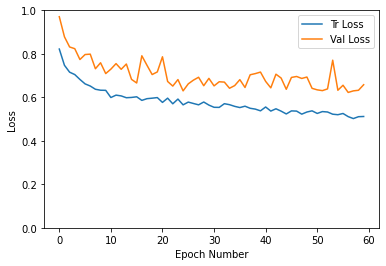

In [ ]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()


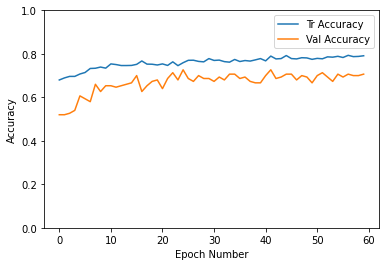

In [ ]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [ ]:
import pdb


In [ ]:
 def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0
    history1 = []

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()
        balacc = 0.0
        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)
            
            from sklearn.metrics import balanced_accuracy_score
            balacc += balanced_accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
            avg_test_loss = test_loss/test_data_size 
            avg_test_acc = test_acc/test_data_size

            history1.append([avg_test_loss,avg_test_acc])

    # Find average test loss and test accuracy
   

    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    balacc = balacc / len(test_data_loader)
    print("Test accuracy : " + str(avg_test_acc))
    print("Test BMA : " + str(balacc))
    print("Test loss : " + str(avg_test_loss))
    

    
    #bacc= balacc.cpu().numpy()
    #pdb.set_trace()
                
    return history1, balacc
       


In [ ]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']


    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)

        topk, topclass = ps.topk(3, dim=1)
        cls = idx_to_class[topclass.cpu().numpy()[0][0]]
        score = topk.cpu().numpy()[0][0]

        whichmax=[]
        for i in range(3):
            print("Prediction", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])
            whichmax.append(topk.cpu().numpy()[0][i])
            #print(whichmax)
            list1=whichmax
            max_value=max(list1)
            max_index=list1.index(max_value)
        #print(max_value)
        print("Prediction final:", idx_to_class[topclass.cpu().numpy()[0][max_index]], ", Score: ", max_value)





Prediction 1 : benign , Score:  1.6065243
Prediction 2 : melanoma , Score:  1.4296273
Prediction 3 : keratosis , Score:  0.14175169
Prediction final: benign , Score:  1.6065243


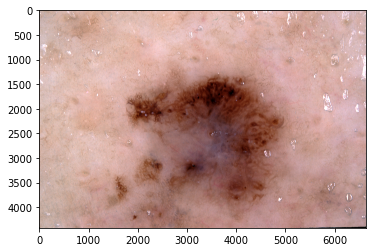

In [ ]:
# Test a particular model on a test image

dataset = '/content/drive/MyDrive/Machinelearning&image/hymenoptera_data'
model = torch.load("{}_model_{}.pt".format(dataset, best_epoch))
predict(model, dataset +'/test/melanoma/ISIC_0014982.jpg')
#predict(model, '/content/drive/MyDrive/Machinelearning&image/ISIC_0014790.jpg')

# Load Data from folders
#computeTestSetAccuracy(model, loss_func)
        
        

In [ ]:
# Load Data from folders
history1,b=computeTestSetAccuracy(model, loss_func)
#b=computeTestSetAccuracy(model,loss_func)
torch.save(history1, dataset+'_history1.pt')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Batch number: 000, Test: Loss: 0.4552, Accuracy: 0.7812


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Batch number: 001, Test: Loss: 0.4050, Accuracy: 0.8438


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Batch number: 002, Test: Loss: 0.4087, Accuracy: 0.8125


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Batch number: 003, Test: Loss: 0.2780, Accuracy: 0.9688


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Batch number: 004, Test: Loss: 0.5501, Accuracy: 0.7500


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Batch number: 005, Test: Loss: 0.4151, Accuracy: 0.8750


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Batch number: 006, Test: Loss: 0.5299, Accuracy: 0.7812


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Batch number: 007, Test: Loss: 0.3853, Accuracy: 0.9375


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Batch number: 008, Test: Loss: 0.3256, Accuracy: 0.8438


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Batch number: 009, Test: Loss: 0.3531, Accuracy: 0.8750


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Batch number: 010, Test: Loss: 0.5518, Accuracy: 0.7188


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Batch number: 011, Test: Loss: 0.4384, Accuracy: 0.8438


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Batch number: 012, Test: Loss: 1.1118, Accuracy: 0.5000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Batch number: 013, Test: Loss: 1.2561, Accuracy: 0.4375


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Batch number: 014, Test: Loss: 1.0704, Accuracy: 0.4688


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Batch number: 015, Test: Loss: 1.2173, Accuracy: 0.4062


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Batch number: 016, Test: Loss: 1.4767, Accuracy: 0.3750


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Batch number: 017, Test: Loss: 1.1952, Accuracy: 0.5000
Test Batch number: 018, Test: Loss: 1.2382, Accuracy: 0.3750
Test accuracy : 0.6933333333333334
Test BMA : 0.6979585864962256
Test loss : 0.7121206108729045


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


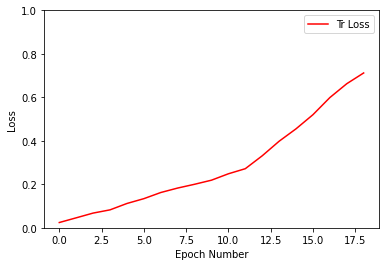

In [ ]:
history1 = np.array(history1)
plt.plot(history1[:,0:1],'r')
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()



In [ ]:
b

0.6979585864962256

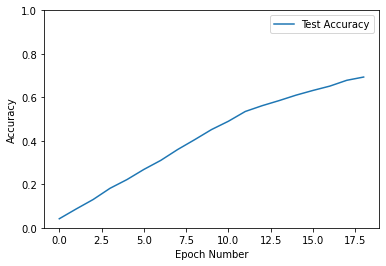

In [ ]:
plt.plot(history1[:,1:2])
plt.legend(['Test Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

ISIC_0014833.jpg
Prediction 1 : melanoma , Score:  0.9420377
Prediction 2 : benign , Score:  0.79797894
Prediction 3 : keratosis , Score:  0.7624869
Prediction final: melanoma , Score:  0.9420377
ISIC_0014787.jpg
Prediction 1 : benign , Score:  3.5583816
Prediction 2 : melanoma , Score:  0.7763772
Prediction 3 : keratosis , Score:  0.05612325
Prediction final: benign , Score:  3.5583816
ISIC_0014798.jpg
Prediction 1 : benign , Score:  2.97954
Prediction 2 : melanoma , Score:  0.42735136
Prediction 3 : keratosis , Score:  0.26500642
Prediction final: benign , Score:  2.97954
ISIC_0014820.jpg
Prediction 1 : benign , Score:  4.541191
Prediction 2 : melanoma , Score:  0.9443441
Prediction 3 : keratosis , Score:  0.06191697
Prediction final: benign , Score:  4.541191
ISIC_0014814.jpg
Prediction 1 : benign , Score:  4.190193
Prediction 2 : melanoma , Score:  0.8745812
Prediction 3 : keratosis , Score:  0.05966091
Prediction final: benign , Score:  4.190193
ISIC_0014786.jpg
Prediction 1 : ben

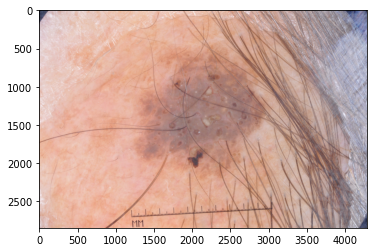

In [ ]:
# Test a particular model on a test image

dataset = '/content/drive/MyDrive/Machinelearning&image/hymenoptera_data'
model = torch.load("{}_model_{}.pt".format(dataset, best_epoch))
onlyfiles = [f for f in listdir(dataset+'/test'+'/benign') if isfile(join(dataset+'/test'+'/benign', f))]
onlyfiles1 = [f for f in listdir(dataset+'/test'+'/melanoma') if isfile(join(dataset+'/test'+'/melanoma', f))]
onlyfiles2 = [f for f in listdir(dataset+'/test'+'/keratosis') if isfile(join(dataset+'/test'+'/keratosis', f))]

for i in range(len(test_directory +'/benign')):
  print(onlyfiles[i])
  predict(model, dataset + '/test'+ '/benign/'+ onlyfiles[i])

for i in range(len(test_directory +'/melanoma')):
  print(onlyfiles1[i])
  predict(model, dataset + '/test'+ '/melanoma/'+ onlyfiles1[i])

for i in range(len(test_directory +'/keratosis')):
  print(onlyfiles2[i])
  predict(model, dataset + '/test'+ '/keratosis/'+ onlyfiles2[i])